In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.speedup import calculate_speedups

sns.set_theme()

## Read data

In [2]:
threads = 32
busy_wait_cycles = [0, 1, 5, 10, 100, 1000, 10000, 100000, 1000000]

our_df = None
master_df = None

for i in range(1, threads + 1):
    for cycles in busy_wait_cycles:
        filename = '05-07-2022/speedup-master-busy-wait-{}-threads-{}-cycles.csv'.format(i, cycles)
        new_df = pd.read_csv(filename)
        new_df['threads'] = i
        new_df['branch'] = '{}'.format(cycles)
        our_df = pd.concat([our_df, new_df], ignore_index = True)
        
    filename = '05-07-2022/speedup-master-{}-threads-10-cycles.csv'.format(i, 10)
    new_master_df = pd.read_csv(filename)
    new_master_df['threads'] = i
    new_master_df['branch'] = 'master'
    master_df = pd.concat([master_df, new_master_df], ignore_index = True)

## Calculate speedups and prepare to plot

In [3]:
speedups_us = calculate_speedups(our_df)
speedups_us_df = pd.DataFrame(data=speedups_us)

speedups_master = calculate_speedups(master_df)
speedups_master_df = pd.DataFrame(data=speedups_master)

df = pd.concat([speedups_us_df, speedups_master_df], ignore_index = True)

## Plot fixed frequency speedups

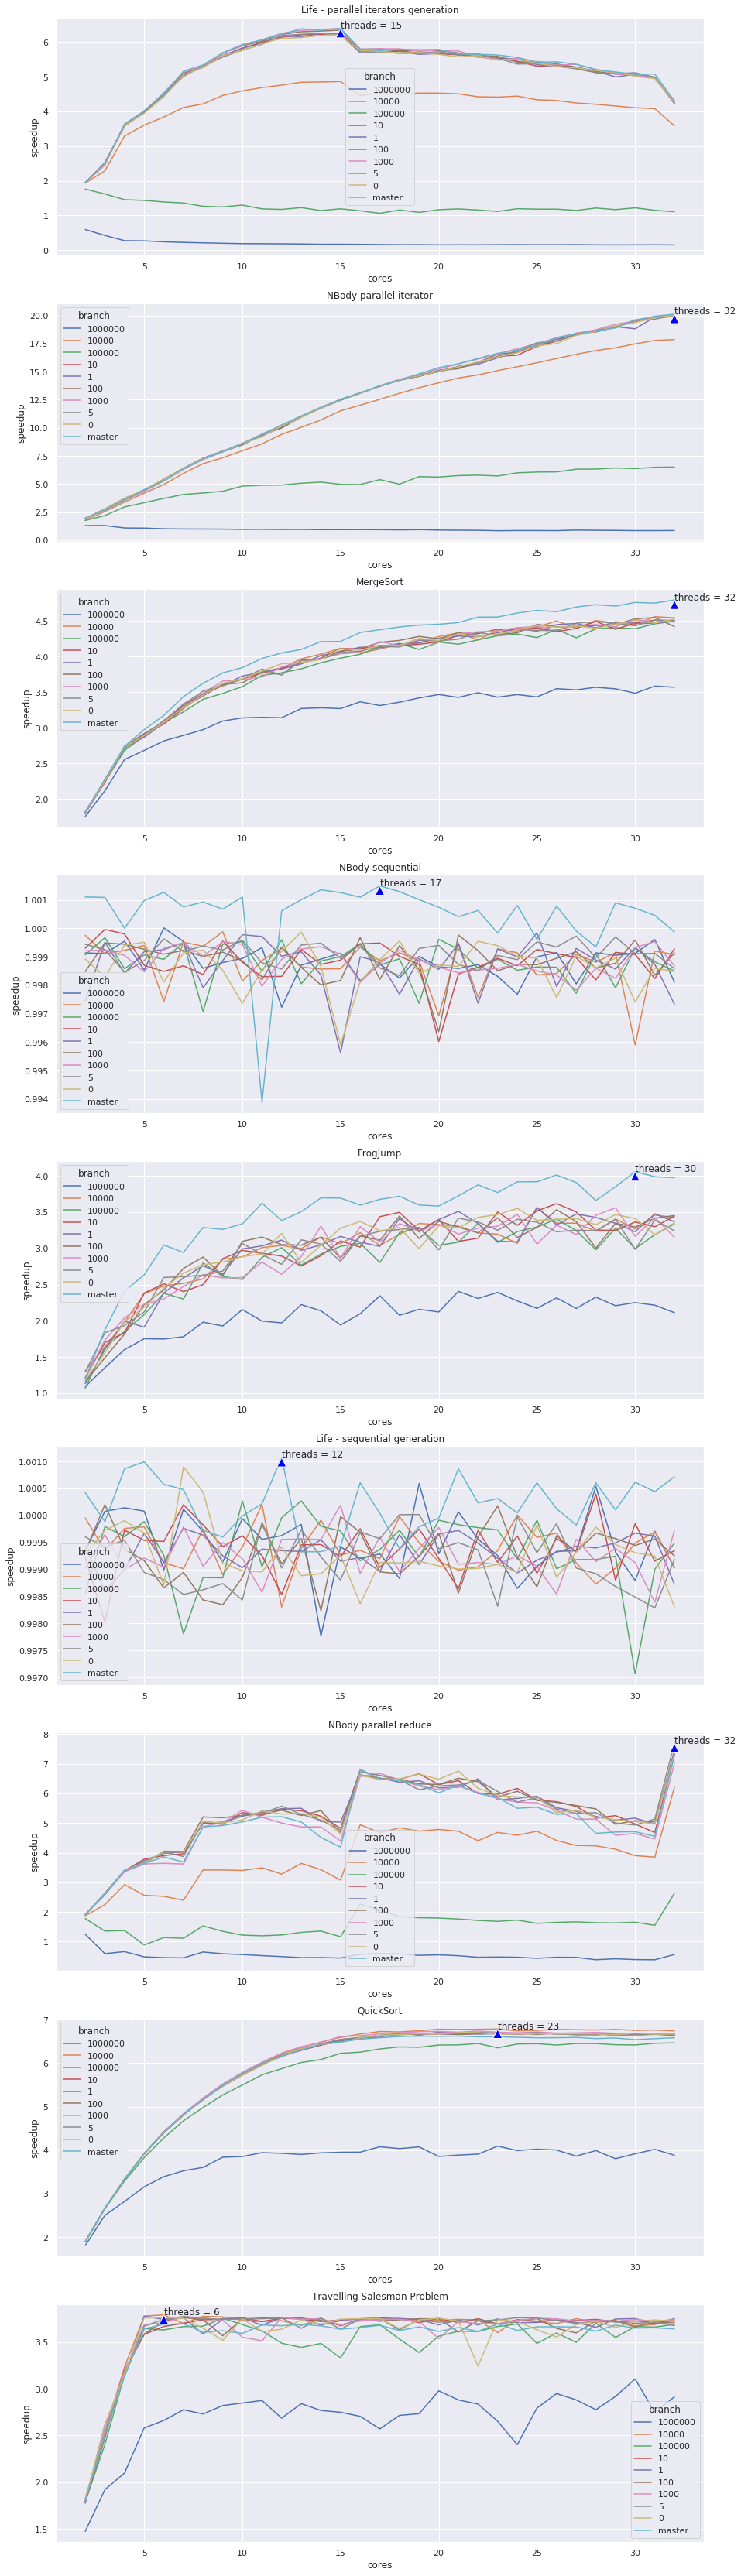

In [4]:
algorithms = set(df['name'])

fig, axs = plt.subplots(len(algorithms), figsize=(15, 60))

for i, algorithm in enumerate(algorithms):
    algorithm_df = df[df['name'] == algorithm]
    
    sns.lineplot(x='cores', y='speedup', hue='branch', data=algorithm_df, ax=axs[i]);
    axs[i].set_title(algorithm);
    
    ymax = max(algorithm_df['speedup'])
    xmax = algorithm_df[algorithm_df['speedup'] == ymax]['cores'].iloc[0]
    axs[i].annotate('threads = {}'.format(xmax), \
                xy=(xmax, ymax), xycoords='data', \
                xytext=(xmax, ymax), textcoords='data', \
                arrowprops=dict(facecolor='blue', shrink=0.05))
    

## Conclusion


Experiments were performed using 0, 1, 5, 10, 100, 1000, 10000, 100000 and 1000000 busy-wait cycles instead of the `thread::yield` call performed by rayon. The thread pool was created **once for each run** and each algorithm was executed 30 times for each number of threads. The busy loop implemented to replace `thread::yield` was exactly the following:

```Rust
for _ in 0..*BUSY_WAIT_CYCLES {
    unsafe { std::arch::asm!("nop") }
}
```

The idea was to use an approach faster than `thread::yield` between failed steal attempts. However, the curves show that for most algorithms, there is no significant differences among rayon's default scheduler and the busy wait scheduler tested by us when it uses less than 1000 busy wait cycles. This can be better visualized when the experiments made using 10000, 100000 and 1000000 are not plotted (this can be achieved by changing the `busy_wait_cycles` list in the _read data_ cell).

Furthermore,  the data shows that the default algorithm performs slightly better than the busy-wait scheduler using 0 cycles, which is odd for me at this point. I'm also not sure if this difference is statistically significant. 

The main hypothesis we had until know to justify the fact that our scheduler had better speedup curves for some algorithms was that we waited less before failed steal attempts, yet the curves show us now that the default scheduler performs better than the busy-wait scheduler with 0 cycles. What could also justify the improvements provided by our algorithm is that our `busy-wait` cycles were increased dynamically during execution and that we used `thread::sleep` calls instead of latches. 

If we look at the `LifeParIter` algorithm, we had a better performance than the default scheduler when using more than 15 threads, as can be seen below (data from experiments/speedup/speedup-500us-1.25-ff.ipynb) 

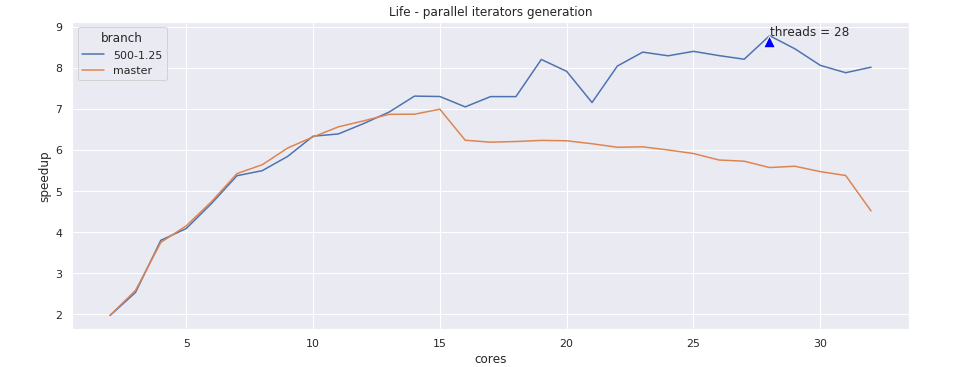

However, we cannot see this difference anymore in today's experiment, which means one or both of the following:

- The improvements seen in the speedup curves were due to increasing the number of busy-wait cycles dynamically (x1.25 until 500us)
- Calling `thread::sleep` instead of blocking on a latch was responsible for the performance improvements.

I'll test the first hypothesis by performing an experiment that multiplies the number of busy-wait cycles by 1.25 whenever a steal attempt fails and that blocks on a latch when the busy waited time is longer than 500 us.